In [2]:
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import cv2
from commonfunctions import show_images 
import numpy as np
import joblib

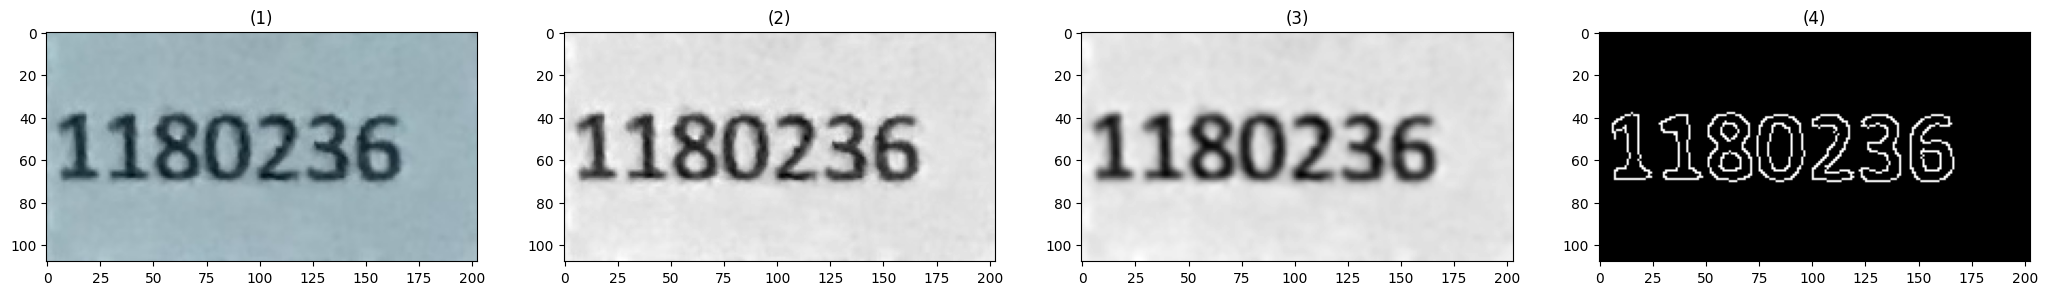

In [9]:
# load the example image
image = cv2.imread("../../Training/Dataset/ids/Cell_5_Test_11.jpg")
# pre-process the image by resizing it, converting it to
# graycale, blurring it, and computing an edge map
# image = imutils.resize(image, height=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 50, 200, 255)

show_images([image,gray,blurred,edged])


In [10]:
# find contours in the edge map, then sort them by their
# size in descending order
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
displayCnt = None
# loop over the contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
	# if the contour has four vertices, then we have found
	# the thermostat display
	if len(approx) == 4:
		displayCnt = approx
		break

In [4]:
# extract the thermostat display, apply a perspective transform
# to it
# warped = four_point_transform(gray, displayCnt.reshape(4, 2))
# output = four_point_transform(image, displayCnt.reshape(4, 2))
# show_images([warped])

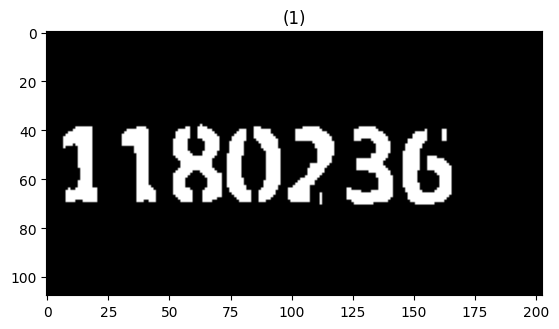

In [11]:
# threshold the warped image, then apply a series of morphological
# operations to cleanup the thresholded image
thresh = cv2.threshold(gray, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 5))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

show_images([thresh])

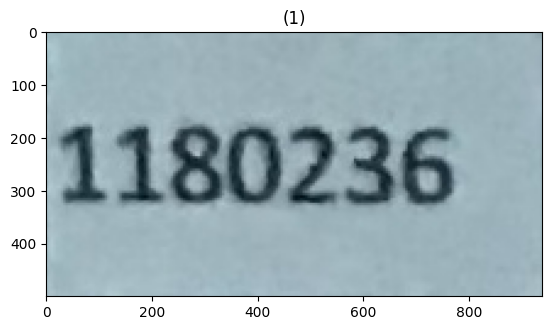

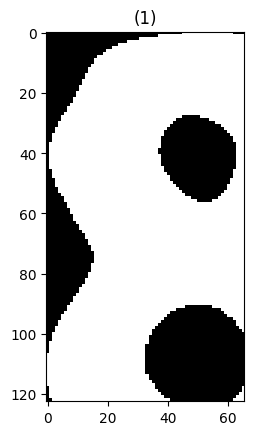

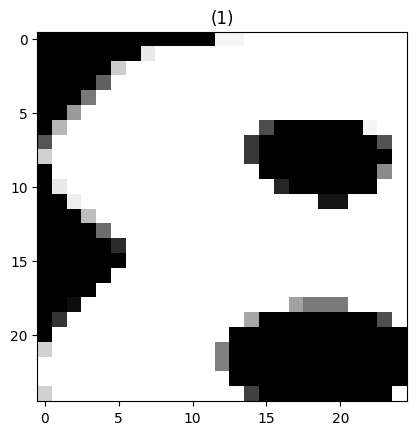

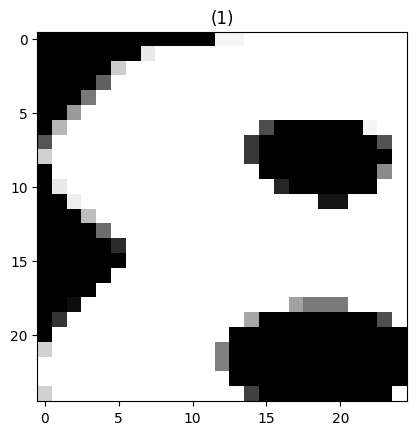

ValueError: X has 625 features, but KNeighborsClassifier is expecting 144 features as input.

In [6]:
knn = joblib.load('./models/knn_model.pkl')

def predict(df):
    predict = knn.predict(df.reshape(1,-1))[0]
    predict_proba = knn.predict_proba(df.reshape(1,-1))
    return predict, predict_proba[0][predict]

def get_img_contour_thresh(img):
    x, y, w, h = 0, 0, 300, 300
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (35, 35), 0)
    ret, thresh1 = cv2.threshold(blur, 70, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    thresh1 = thresh1[y:y + h, x:x + w]
    contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    return img, contours, thresh1

img, contours, thresh = get_img_contour_thresh(image)
show_images([img])
ans1 = ''
ans2 = ''
ans3 = ''
if len(contours) > 0:
    contour = max(contours, key=cv2.contourArea)
    if cv2.contourArea(contour) > 2500:
        # print(predict(w_from_model,b_from_model,contour))
        x, y, w, h = cv2.boundingRect(contour)
        # newImage = thresh[y - 15:y + h + 15, x - 15:x + w +15]
        newImage = thresh[y:y + h, x:x + w]
        show_images([newImage])
        newImage = cv2.resize(newImage, (25, 25))
        show_images([newImage])
        newImage = np.array(newImage)
        show_images([newImage])
        # newImage = newImage.flatten()
        # newImage = newImage.reshape(newImage.shape[0], 1)
        ans1 = predict(newImage)

x, y, w, h = 0, 0, 300, 300
cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
cv2.putText(img, "Logistic Regression : " + str(ans1), (10, 320),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
cv2.putText(img, "Shallow Network :  " + str(ans2), (10, 350),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
cv2.putText(img, "Deep Network :  " + str(ans3), (10, 380),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
cv2.imshow("Frame", img)
cv2.imshow("Contours", thresh)
k = cv2.waitKey(10)
if k == 27:
    break

In [ ]:
# find contours in the thresholded image, then initialize the
# digit contours lists
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
digitCnts = []
# loop over the digit area candidates
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
	print(x, y, w, h)
	# if the contour is sufficiently large, it must be a digit
	if w >= 80 and (h >= 140 and h <= 150):
		digitCnts.append(c)


# print(cnts[0])

675 185 97 144
569 181 92 147
458 180 92 148
338 180 106 144
135 180 87 144
28 180 87 144
236 176 102 148


In [ ]:
digitCnts = contours.sort_contours(digitCnts,
	method="left-to-right")[0]
digits = []

In [ ]:
# loop over each of the digits
for c in digitCnts:
	# extract the digit ROI
	(x, y, w, h) = cv2.boundingRect(c)
	roi = thresh[y:y + h, x:x + w]
	# compute the width and height of each of the 7 segments
	# we are going to examine
	(roiH, roiW) = roi.shape
	(dW, dH) = (int(roiW * 0.25), int(roiH * 0.15))
	dHC = int(roiH * 0.05)
	# define the set of 7 segments
	segments = [
		((0, 0), (w, dH)),	# top
		((0, 0), (dW, h // 2)),	# top-left
		((w - dW, 0), (w, h // 2)),	# top-right
		((0, (h // 2) - dHC) , (w, (h // 2) + dHC)), # center
		((0, h // 2), (dW, h)),	# bottom-left
		((w - dW, h // 2), (w, h)),	# bottom-right
		((0, h - dH), (w, h))	# bottom
	]
	on = [0] * len(segments)

  

In [ ]:
DIGITS_LOOKUP = {
(1, 1, 1, 0, 1, 1, 1): 0,
(0, 0, 1, 0, 0, 1, 0): 1,
(1, 0, 1, 1, 1, 1, 0): 2,
(1, 0, 1, 1, 0, 1, 1): 3,
(0, 1, 1, 1, 0, 1, 0): 4,
(1, 1, 0, 1, 0, 1, 1): 5,
(1, 1, 0, 1, 1, 1, 1): 6,
(1, 0, 1, 0, 0, 1, 0): 7,
(1, 1, 1, 1, 1, 1, 1): 8,
(1, 1, 1, 1, 0, 1, 1): 9
}

# loop over the segments
for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
	# extract the segment ROI, count the total number of
	# thresholded pixels in the segment, and then compute
	# the area of the segment
	segROI = roi[yA:yB, xA:xB]
	total = cv2.countNonZero(segROI)
	area = (xB - xA) * (yB - yA)
	# if the total number of non-zero pixels is greater than
	# 50% of the area, mark the segment as "on"
	if total / float(area) > 0.5:
		on[i]= 1
# lookup the digit and draw it on the image
digit = DIGITS_LOOKUP[tuple(on)]
digits.append(digit)
cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
cv2.putText(output, str(digit), (x - 10, y - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
# 
# display the digits
print(u"{}{}.{} \u00b0C".format(*digits))
cv2.imshow("Input", image)
cv2.imshow("Output", output)
cv2.waitKey(0)
